# A* với 8-Puzzle — Báo cáo Giữa Kỳ (AI_N01)

**Sinh viên:** _Điền tên_  
**MSSV:** _Điền MSSV_  
**Môn:** Trí tuệ nhân tạo — Lớp N01

---

Notebook hiện thực **8-Puzzle** với **A\***, dùng **2 heuristic** (`h_zero`, `h_pair`), minh hoạ **cây tìm kiếm với n nút**, và thí nghiệm so sánh với **BFS** về **time/space/cost**.

> **Windows & Graphviz**: Để xuất PNG, cài **Graphviz (dot.exe)** và thêm vào `PATH`. Notebook có sẵn fallback ghi file `.dot`.

## 1. Mô tả bài toán & mô hình hoá state space

- **Trạng thái**: ma trận `3x3` số `0..8`, `0` là ô trống.
- **Tập goal** (4 trạng thái theo đề):  
  1. 1 2 3 / 4 5 6 / 7 8 0  
  2. 8 7 6 / 5 4 3 / 2 1 0  
  3. 0 1 2 / 3 4 5 / 6 7 8  
  4. 0 8 7 / 6 5 4 / 3 2 1
- **Hành động** (mỗi bước cost = 1):
  1. Di chuyển ô trống `U/D/L/R` (nếu hợp lệ).
  2. **Swap** hai ô **kề nhau** theo ngang/dọc **thoả** `A + B = 9` (không swap ô trống).
  3. **Swap góc chéo**: `TL↔BR`, `TR↔BL` (ô trống không được swap).

## 2. Heuristics (2 cái theo đúng yêu cầu)
- `h_zero(s) = 0`: baseline, **admissible** & **consistent**.
- `h_pair(s) = ceil(misplaced(s) / 2)`: với \`misplaced(s)\` là số ô sai vị trí (tối ưu theo 4 goal).  
  - **Admissible**: mỗi bước tối đa sửa 2 ô ⇒ số bước tối thiểu ≥ ceil(mis/2).  
  - **Consistent**: mỗi bước `h` giảm nhiều nhất 1 ⇒ `h(n) ≤ 1 + h(n')`.

### Gợi ý cài Graphviz (muốn xuất PNG)
- Windows: `winget install Graphviz.Graphviz`  hoặc  `choco install graphviz`  
- Kiểm tra: `dot -V`  
- Nếu chưa có `PATH`, chỉnh biến `DOT = r"C:\\Program Files\\Graphviz\\bin\\dot.exe"` ở cuối notebook.

In [19]:
from __future__ import annotations
from dataclasses import dataclass, field
from typing import Any, Callable, Dict, Iterable, List, Optional, Tuple, Set
import heapq, random, time, os, shutil
from collections import deque
from IPython.display import Image, display

# Kiểu trạng thái
Grid = Tuple[Tuple[int, int, int], Tuple[int, int, int], Tuple[int, int, int]]

In [3]:
# Hỗ trợ Graphviz 'dot' (tự dò dot.exe khi cần)\n
def _inject_dot_into_env(dot_path: Optional[str]) -> None:
    if not dot_path:
        return
    if os.path.isdir(dot_path):
        dot_path = os.path.join(dot_path, "dot.exe")
    if os.path.isfile(dot_path):
        dot_dir = os.path.dirname(dot_path)
        os.environ["PATH"] = f"{dot_dir};" + os.environ.get("PATH", "")
        os.environ["GRAPHVIZ_DOT"] = dot_path

def _ensure_dot_available(extra_candidates: Optional[List[str]] = None) -> Optional[str]:
    cur = shutil.which("dot")
    if cur:
        return cur
    candidates = [
        r"C:\\Program Files\\Graphviz\\bin\\dot.exe",
        r"C:\\Program Files (x86)\\Graphviz2.38\\bin\\dot.exe",
        os.path.join(os.environ.get("CONDA_PREFIX", ""), r"Library\\bin\\dot.exe"),
    ]
    if extra_candidates:
        candidates = extra_candidates + candidates
    for p in candidates:
        if p and os.path.isfile(p):
            _inject_dot_into_env(p)
            return p
    return None

In [4]:
# Utilities (8-puzzle)\n
def find_pos(g: Grid, val: int) -> Tuple[int, int]:
    for i in range(3):
        for j in range(3):
            if g[i][j] == val:
                return (i, j)
    raise ValueError("Value not found")

def swap_cells(g: Grid, p1: Tuple[int, int], p2: Tuple[int, int]) -> Grid:
    (i1, j1), (i2, j2) = p1, p2
    lst = [list(row) for row in g]
    lst[i1][j1], lst[i2][j2] = lst[i2][j2], lst[i1][j1]
    return tuple(tuple(row) for row in lst)

def move_blank(g: Grid, direction: str) -> Optional[Grid]:
    di = {"U": -1, "D": 1, "L": 0, "R": 0}
    dj = {"U": 0, "D": 0, "L": -1, "R": 1}
    bi, bj = find_pos(g, 0)
    ni, nj = bi + di[direction], bj + dj[direction]
    if 0 <= ni < 3 and 0 <= nj < 3:
        return swap_cells(g, (bi, bj), (ni, nj))
    return None

In [5]:
# Định nghĩa Problem + 8-Puzzle theo đúng luật đề\n
@dataclass(frozen=True)
class Action:
    kind: str  # "move" | "swap9" | "swap_corners"
    detail: str
    def __str__(self) -> str:
        return f"{self.kind}:{self.detail}"

class Problem:
    def __init__(self, initial: Any):
        self.initial = initial
    def is_goal(self, state: Any) -> bool: ...
    def actions(self, state: Any) -> Iterable[Action]: ...
    def result(self, state: Any, action: Action) -> Any: ...
    def step_cost(self, state: Any, action: Action, next_state: Any) -> float:
        return 1.0

class EightPuzzleProblem(Problem):
    def __init__(self, initial: Grid, goals: Optional[List[Grid]] = None):
        super().__init__(initial)
        if goals is None:
            self.goals: List[Grid] = [
                ((1,2,3), (4,5,6), (7,8,0)),
                ((8,7,6), (5,4,3), (2,1,0)),
                ((0,1,2), (3,4,5), (6,7,8)),
                ((0,8,7), (6,5,4), (3,2,1)),
            ]
        else:
            self.goals = goals

    def is_goal(self, state: Grid) -> bool:
        return state in self.goals

    def actions(self, state: Grid) -> Iterable[Action]:
        # 1) Di chuyển ô trống
        for d in ("U", "D", "L", "R"):
            if move_blank(state, d) is not None:
                yield Action("move", d)
        # 2) Swap kề nhau thoả A+B=9 (không swap 0)
        dirs = [(1,0), (-1,0), (0,1), (0,-1)]
        for i in range(3):
            for j in range(3):
                a = state[i][j]
                if a == 0:
                    continue
                for di, dj in dirs:
                    ni, nj = i + di, j + dj
                    if 0 <= ni < 3 and 0 <= nj < 3:
                        b = state[ni][nj]
                        if b != 0 and a + b == 9 and (i, j) < (ni, nj):
                            yield Action("swap9", f"({i},{j})<->({ni},{nj})")
        # 3) Swap góc chéo (trừ khi có 0 ở góc)
        corners = {"TL_BR": ((0,0), (2,2)), "TR_BL": ((0,2), (2,0))}
        for name, ((i1,j1),(i2,j2)) in corners.items():
            if state[i1][j1] != 0 and state[i2][j2] != 0:
                yield Action("swap_corners", name)

    def result(self, state: Grid, action: Action) -> Grid:
        if action.kind == "move":
            nxt = move_blank(state, action.detail)
            assert nxt is not None
            return nxt
        elif action.kind == "swap9":
            lhs, rhs = action.detail.split("<->")
            i, j   = map(int, lhs.strip()[1:-1].split(","))
            ni, nj = map(int, rhs.strip()[1:-1].split(","))
            return swap_cells(state, (i,j), (ni,nj))
        elif action.kind == "swap_corners":
            return swap_cells(state, (0,0), (2,2)) if action.detail=="TL_BR" else swap_cells(state, (0,2), (2,0))
        else:
            raise ValueError("Unknown action")

In [6]:
# Node + Heuristics (2 cái)\n
@dataclass(order=True)
class Node:
    f: float
    id: int = field(compare=False)
    state: Any = field(compare=False)
    g: float = field(compare=False, default=0.0)
    parent: Optional["Node"] = field(compare=False, default=None)
    action: Optional[Action] = field(compare=False, default=None)
    def path(self) -> List["Node"]:
        cur: Optional[Node] = self; out: List[Node] = []
        while cur is not None:
            out.append(cur); cur = cur.parent
        return out[::-1]

def misplaced_tiles_min_over_goals(state: Grid, goals: List[Grid]) -> int:
    best = 9
    for g in goals:
        cnt = 0
        for i in range(3):
            for j in range(3):
                if state[i][j] != 0 and state[i][j] != g[i][j]:
                    cnt += 1
        best = min(best, cnt)
    return best

def h_zero(state: Grid, problem: EightPuzzleProblem) -> float:
    return 0.0

def h_pair(state: Grid, problem: EightPuzzleProblem) -> float:
    mis = misplaced_tiles_min_over_goals(state, problem.goals)
    return float((mis + 1) // 2)

In [7]:
# A* tổng quát\n
class AStar:
    def __init__(self, problem: Problem, heuristic: Callable[[Any, Problem], float]):
        self.problem = problem; self.heuristic = heuristic
        self._next_id = 0; self.expanded_nodes = 0
        self.trace_edges: List[Tuple[int, int, str]] = []; self._id2state: Dict[int, Any] = {}

    def _new_id(self) -> int:
        self._next_id += 1; return self._next_id

    def solve(self, max_expansions: Optional[int] = None) -> Optional[Node]:
        start = Node(f=0.0, id=self._new_id(), state=self.problem.initial, g=0.0, parent=None, action=None)
        self._id2state[start.id] = start.state
        start.f = start.g + self.heuristic(start.state, self.problem)
        frontier: List[Node] = []; heapq.heappush(frontier, start)
        g_best: Dict[Any, float] = {start.state: 0.0}; closed: Set[Any] = set()
        while frontier:
            cur = heapq.heappop(frontier)
            if self.problem.is_goal(cur.state): return cur
            if cur.state in closed: continue
            closed.add(cur.state)
            self.expanded_nodes += 1
            if max_expansions is not None and self.expanded_nodes >= max_expansions: return None
            for act in self.problem.actions(cur.state):
                nxt_state = self.problem.result(cur.state, act)
                new_g = cur.g + self.problem.step_cost(cur.state, act, nxt_state)
                if nxt_state in g_best and new_g >= g_best[nxt_state]: continue
                g_best[nxt_state] = new_g
                child = Node(f=0.0, id=self._new_id(), state=nxt_state, g=new_g, parent=cur, action=act)
                child.f = child.g + self.heuristic(child.state, self.problem)
                self._id2state[child.id] = child.state
                heapq.heappush(frontier, child)
                self.trace_edges.append((cur.id, child.id, str(act)))
        return None

    def export_search_tree_dot(self, limit_edges: int = 100) -> str:
        lines = ["digraph G {", '  node [shape=box, fontsize=10];']
        used_nodes: Set[int] = set()
        def state_label(state: Grid) -> str:
            flat = sum(state, ())
            return "\\n".join([
                f"{flat[0]} {flat[1]} {flat[2]}",
                f"{flat[3]} {flat[4]} {flat[5]}",
                f"{flat[6]} {flat[7]} {flat[8]}",
            ])
        for (p, c, a) in self.trace_edges[:limit_edges]:
            used_nodes.add(p); used_nodes.add(c)
            lines.append(f'  {p} -> {c} [label="{a}", fontsize=9];')
        for nid in used_nodes:
            st = self._id2state.get(nid)
            if st is not None:
                lbl = state_label(st)
                lines.append(f'  {nid} [label="{lbl}"];')
        lines.append("}"); return "\n".join(lines)

In [8]:
# BFS (để so sánh)\n
class BFS:
    def __init__(self, problem: Problem):
        self.problem = problem; self.expanded_nodes = 0
    def solve(self, max_expansions: Optional[int] = None) -> Optional[Node]:
        start = Node(f=0.0, id=0, state=self.problem.initial, g=0.0, parent=None, action=None)
        q = deque([start]); visited: Set[Any] = {start.state}
        while q:
            cur = q.popleft()
            if self.problem.is_goal(cur.state): return cur
            self.expanded_nodes += 1
            if max_expansions is not None and self.expanded_nodes >= max_expansions: return None
            for act in self.problem.actions(cur.state):
                nxt = self.problem.result(cur.state, act)
                if nxt not in visited:
                    visited.add(nxt)
                    child = Node(f=0.0, id=0, state=nxt, g=cur.g + 1, parent=cur, action=act)
                    q.append(child)
        return None

In [9]:
# Sinh trạng thái ngẫu nhiên từ 1 goal + khung thí nghiệm\n
def random_state_from_goal(problem: EightPuzzleProblem, steps: int = 50, seed: Optional[int] = None) -> Grid:
    rnd = random.Random(seed); goal = rnd.choice(problem.goals); s: Grid = goal
    for _ in range(steps):
        acts = list(problem.actions(s))
        if not acts: break
        a = rnd.choice(acts); s = problem.result(s, a)
    return s

from dataclasses import dataclass
@dataclass
class RunStats:
    found: bool; path_cost: Optional[int]; expanded: int; elapsed_sec: float

def run_once_with_solver(solver_factory: Callable[[], Any]) -> RunStats:
    t0 = time.perf_counter(); solver = solver_factory()
    if isinstance(solver, AStar):
        goal = solver.solve(); elapsed = time.perf_counter() - t0
        return RunStats(goal is not None, None if goal is None else int(goal.g), solver.expanded_nodes, elapsed)
    elif isinstance(solver, BFS):
        goal = solver.solve(); elapsed = time.perf_counter() - t0
        return RunStats(goal is not None, None if goal is None else int(goal.g), solver.expanded_nodes, elapsed)
    else: raise ValueError("Unknown solver")

def experiment_compare(initial_states: List[Grid], goals: Optional[List[Grid]] = None) -> Dict[str, List[RunStats]]:
    results: Dict[str, List[RunStats]] = {"A*_h0": [], "A*_hpair": [], "BFS": []}
    for s in initial_states:
        prob = EightPuzzleProblem(s, goals=goals)
        results["A*_h0"].append(run_once_with_solver(lambda p=prob: AStar(p, h_zero)))
        results["A*_hpair"].append(run_once_with_solver(lambda p=prob: AStar(p, h_pair)))
        results["BFS"].append(run_once_with_solver(lambda p=prob: BFS(p)))
    return results

def summarize_results(results: Dict[str, List[RunStats]]) -> Dict[str, Dict[str, float]]:
    summary: Dict[str, Dict[str, float]] = {}
    for name, stats in results.items():
        founds = [s for s in stats if s.found]
        summary[name] = {
            "trials": float(len(stats)),
            "found_rate": float(len(founds)) / max(1, len(stats)),
            "avg_cost": (sum(s.path_cost for s in founds if s.path_cost is not None) / max(1, len(founds))) if founds else float("nan"),
            "avg_expanded": sum(s.expanded for s in stats) / max(1, len(stats)),
            "avg_time_ms": 1000.0 * (sum(s.elapsed_sec for s in stats) / max(1, len(stats))),
        }
    return summary

def print_table_from_summary(title: str, summary: Dict[str, Dict[str, float]]) -> None:
    print(f"\nBẢNG 4 — {title}")
    print("=" * 90)
    print(f"{'Thuật toán':<26}{'Trials':>8}{'Found%':>10}{'Avg Cost':>12}{'Avg Expanded':>15}{'Avg Time (ms)':>15}")
    print("-" * 90)
    order = ["A*_h0", "A*_hpair", "BFS"]
    for k in order:
        if k in summary:
            row = summary[k]
            print(f"{k:<26}{row['trials']:>8.0f}{row['found_rate']*100:>9.1f}%{row['avg_cost']:>12.2f}{row['avg_expanded']:>15.2f}{row['avg_time_ms']:>15.2f}")
    for k, row in summary.items():
        if k not in order:
            print(f"{k:<26}{row['trials']:>8.0f}{row['found_rate']*100:>9.1f}%{row['avg_cost']:>12.2f}{row['avg_expanded']:>15.2f}{row['avg_time_ms']:>15.2f}")
    print("=" * 90)

In [10]:
# In trạng thái/đường đi + Đánh giá heuristic\n
def print_grid(g: Grid) -> None:
    for i in range(3):
        print(" ".join(str(x) for x in g[i]))
    print()

def print_solution(node: Optional[Node]) -> None:
    if node is None:
        print("No solution."); return
    path = node.path()
    print(f"Path length (cost): {int(path[-1].g)}  |  steps = {len(path)-1}")
    for k, nd in enumerate(path):
        print(f"Step {k}:"); print_grid(nd.state)
        if nd.action:
            print(f"Action: {nd.action}"); print("-"*20)

def bfs_optimal_cost_from_state(problem: Problem, start_state: Grid) -> int:
    q = deque([(start_state, 0)]); seen = {start_state}
    while q:
        s, d = q.popleft()
        if problem.is_goal(s): return d
        for act in problem.actions(s):
            ns = problem.result(s, act)
            if ns not in seen:
                seen.add(ns); q.append((ns, d + 1))
    return float("inf")

def evaluate_admissibility_along_path(problem: EightPuzzleProblem,
                                      heuristic: Callable[[Grid, EightPuzzleProblem], float],
                                      solution_node: Node) -> List[dict]:
    print("\nBẢNG — ADMISSIBLE (h(n) ≤ h*(n)) DỌC THEO ĐƯỜNG ĐI NGHIỆM")
    print("=" * 80)
    print(f"{'Bước':<8}{'h(n)':<12}{'h*(n) = cost tối ưu':<24}{'Kết luận'}")
    print("-" * 80)
    rows: List[dict] = []
    for k, nd in enumerate(solution_node.path()):
        h_n = heuristic(nd.state, problem)
        h_star = bfs_optimal_cost_from_state(problem, nd.state)
        ok = h_n <= h_star
        rows.append({"step": k, "h": h_n, "h_star": h_star, "ok": ok})
        print(f"{k:<8}{int(h_n):<12}{h_star:<24}{'Đúng' if ok else 'Sai'}")
    print("=" * 80)
    return rows

def evaluate_consistency_for_state(problem: EightPuzzleProblem,
                                   heuristic: Callable[[Grid, EightPuzzleProblem], float],
                                   state: Grid) -> List[dict]:
    print("\nBẢNG — CONSISTENT TẠI 1 TRẠNG THÁI (h(n) ≤ 1 + h(n'))")
    print("=" * 110)
    # Dùng .format để tránh backslash trong f-string
    print("{:<10}{:<10}{:<12}{:<14}{:<12}{}".format(
        "Kế thừa", "h(n)", "h(n')", "1 + h(n')", "Kết luận", "Hành động"
    ))
    print("-" * 110)
    rows: List[dict] = []
    h_n = heuristic(state, problem)
    idx = 0
    for act in problem.actions(state):
        nstate = problem.result(state, act)
        h_np = heuristic(nstate, problem)
        consistent = h_n <= 1 + h_np
        idx += 1
        rows.append({"k": idx, "action": str(act), "h_n": h_n, "h_np": h_np, "ok": consistent})
        print("{:<10}{:<10}{:<12}{:<14}{:<12}{}".format(
            idx, int(h_n), int(h_np), int(1 + h_np), "Đúng" if consistent else "Sai", act
        ))
    print("=" * 110)
    return rows

def evaluate_consistency_along_path(problem: EightPuzzleProblem,
                                    heuristic: Callable[[Grid, EightPuzzleProblem], float],
                                    solution_node: Node,
                                    max_steps: int = 8) -> List[List[dict]]:
    print(f"\nBẢNG — CONSISTENT TRÊN {max_steps} BƯỚC ĐẦU CỦA ĐƯỜNG ĐI NGHIỆM")
    all_rows: List[List[dict]] = []
    path = solution_node.path()
    upto = min(len(path), max_steps)
    for k in range(upto):
        print(f"\n--- Trạng thái tại bước {k} ---")
        rows = evaluate_consistency_for_state(problem, heuristic, path[k].state)
        all_rows.append(rows)
    return all_rows

## 3. Demo chạy nhanh (A* với 2 heuristic & BFS)

In [11]:
initial: Grid = ((2, 8, 3),
                 (1, 6, 4),
                 (7, 0, 5))
problem = EightPuzzleProblem(initial)

print("=== A* with h_pair ===")
astar = AStar(problem, h_pair)
goal = astar.solve()
print_solution(goal)
print(f"Expanded nodes: {astar.expanded_nodes}")

print("=== A* with h_zero ===")
astar0 = AStar(problem, h_zero)
goal0 = astar0.solve()
print_solution(goal0)
print(f"Expanded nodes: {astar0.expanded_nodes}")

print("=== BFS ===")
bfs_solver = BFS(problem)
goal_b = bfs_solver.solve()
print_solution(goal_b)
print(f"Expanded nodes: {bfs_solver.expanded_nodes}")

=== A* with h_pair ===
Path length (cost): 14  |  steps = 14
Step 0:
2 8 3
1 6 4
7 0 5

Step 1:
2 8 3
1 0 4
7 6 5

Action: move:U
--------------------
Step 2:
2 8 3
0 1 4
7 6 5

Action: move:L
--------------------
Step 3:
0 8 3
2 1 4
7 6 5

Action: move:U
--------------------
Step 4:
8 0 3
2 1 4
7 6 5

Action: move:R
--------------------
Step 5:
8 1 3
2 0 4
7 6 5

Action: move:D
--------------------
Step 6:
8 1 3
2 4 0
7 6 5

Action: move:R
--------------------
Step 7:
8 1 3
2 4 5
7 6 0

Action: move:D
--------------------
Step 8:
8 1 3
2 4 5
7 0 6

Action: move:L
--------------------
Step 9:
8 1 3
2 4 5
0 7 6

Action: move:L
--------------------
Step 10:
8 1 3
0 4 5
2 7 6

Action: move:U
--------------------
Step 11:
8 1 2
0 4 5
3 7 6

Action: swap_corners:TR_BL
--------------------
Step 12:
6 1 2
0 4 5
3 7 8

Action: swap_corners:TL_BR
--------------------
Step 13:
0 1 2
6 4 5
3 7 8

Action: move:U
--------------------
Step 14:
0 1 2
3 4 5
6 7 8

Action: swap9:(1,0)<->(2,0)
---------

## 4. Đánh giá heuristic (đúng yêu cầu: **mỗi heuristic 2 bảng**)
- **BẢNG A1**: Admissible cho `h_pair` (dọc theo đường đi nghiệm).  
- **BẢNG A2**: Consistent cho `h_pair` (trên K trạng thái đầu đường đi nghiệm).  
- **BẢNG B1**: Admissible cho `h_zero`.  
- **BẢNG B2**: Consistent cho `h_zero`.

In [12]:
K = 8  # số bước đầu để kiểm tra consistency

if goal is not None:
    print("\n### Heuristic: h_pair")
    print("BẢNG A1 — Admissible (h(n) ≤ h*(n)) — h_pair")
    _ = evaluate_admissibility_along_path(problem, h_pair, goal)
    print(f"BẢNG A2 — Consistent (h(n) ≤ 1 + h(n')) trên {K} bước đầu — h_pair")
    _ = evaluate_consistency_along_path(problem, h_pair, goal, max_steps=K)
else:
    print("Không có lời giải (h_pair) để đánh giá.")

if goal0 is not None:
    print("\n### Heuristic: h_zero")
    print("BẢNG B1 — Admissible (h(n) ≤ h*(n)) — h_zero")
    _ = evaluate_admissibility_along_path(problem, h_zero, goal0)
    print(f"BẢNG B2 — Consistent (h(n) ≤ 1 + h(n')) trên {K} bước đầu — h_zero")
    _ = evaluate_consistency_along_path(problem, h_zero, goal0, max_steps=K)
else:
    print("Không có lời giải (h_zero) để đánh giá.")


### Heuristic: h_pair
BẢNG A1 — Admissible (h(n) ≤ h*(n)) — h_pair

BẢNG — ADMISSIBLE (h(n) ≤ h*(n)) DỌC THEO ĐƯỜNG ĐI NGHIỆM
Bước    h(n)        h*(n) = cost tối ưu     Kết luận
--------------------------------------------------------------------------------
0       3           14                      Đúng
1       3           13                      Đúng
2       3           12                      Đúng
3       3           11                      Đúng
4       3           10                      Đúng
5       3           9                       Đúng
6       3           8                       Đúng
7       3           7                       Đúng
8       3           6                       Đúng
9       2           5                       Đúng
10      2           4                       Đúng
11      2           3                       Đúng
12      1           2                       Đúng
13      1           1                       Đúng
14      0           0                       Đúng
BẢNG

## 5. Thí nghiệm so sánh A* (2 heuristic) và BFS
Sinh ngẫu nhiên `M` trạng thái từ 1 goal (đảm bảo reachable theo luật), đo **cost**, **số nút mở rộng**, **thời gian**.

In [13]:
M = 8
base_goal_problem = EightPuzzleProblem(((1,2,3),(4,5,6),(7,8,0)))
initials = [random_state_from_goal(base_goal_problem, steps=40, seed=100+i) for i in range(M)]

res = experiment_compare(initials)
summary = summarize_results(res)
print("\n=== Summary (A*_h0 vs A*_hpair vs BFS) ===")
for name, row in summary.items():
    print(name, row)
print_table_from_summary("So sánh A* (h0) vs A* (h_pair) vs BFS", summary)


=== Summary (A*_h0 vs A*_hpair vs BFS) ===
A*_h0 {'trials': 8.0, 'found_rate': 1.0, 'avg_cost': 6.25, 'avg_expanded': 3143.0, 'avg_time_ms': 231.16151250360417}
A*_hpair {'trials': 8.0, 'found_rate': 1.0, 'avg_cost': 6.25, 'avg_expanded': 295.5, 'avg_time_ms': 23.862450001615798}
BFS {'trials': 8.0, 'found_rate': 1.0, 'avg_cost': 6.25, 'avg_expanded': 3619.25, 'avg_time_ms': 227.17472500153235}

BẢNG 4 — So sánh A* (h0) vs A* (h_pair) vs BFS
Thuật toán                  Trials    Found%    Avg Cost   Avg Expanded  Avg Time (ms)
------------------------------------------------------------------------------------------
A*_h0                            8    100.0%        6.25        3143.00         231.16
A*_hpair                         8    100.0%        6.25         295.50          23.86
BFS                              8    100.0%        6.25        3619.25         227.17


## 6. Minh hoạ cây tìm kiếm
- **Theo số cạnh** (`max_edges`) hoặc **đúng n NÚT** (`max_nodes`).
- Thiếu `dot.exe` ⇒ sẽ xuất `.dot` để render thủ công.

In [ ]:
def render_search_tree_png(astar: AStar, max_edges: int = 100, filename: str = "search_tree",
                           dot_path: Optional[str] = None, show_inline: bool = True):
    try:
        from graphviz import Digraph
    except Exception as e:
        dot_src = astar.export_search_tree_dot(limit_edges=max_edges)
        with open(f"{filename}.dot", "w", encoding="utf-8") as f:
            f.write(dot_src)
        print(f"Graphviz (Python) chưa sẵn sàng ({e}). Đã ghi DOT vào {filename}.dot")
        print(f">> Render thủ công: dot -Tpng {filename}.dot -o {filename}.png")
        return None

    if dot_path:
        _inject_dot_into_env(dot_path)
    else:
        _ensure_dot_available()

    dot = Digraph(format="png")
    used_nodes: set[int] = set()

    for (p, c, a) in astar.trace_edges[:max_edges]:
        used_nodes.add(p); used_nodes.add(c)
        dot.edge(str(p), str(c), label=a)

    def label_for_state(state: Grid) -> str:
        return "\n".join(" ".join("_" if v == 0 else str(v) for v in row) for row in state)

    for nid in used_nodes:
        st = astar._id2state.get(nid)
        if st is not None:
            dot.node(str(nid), label_for_state(st))

    try:
        path = dot.render(filename=filename, cleanup=True)
        print(f"Search tree rendered to: {path}")
        if show_inline:
            display(Image(filename=path))
        return path
    except Exception as e:
        dot_src = astar.export_search_tree_dot(limit_edges=max_edges)
        with open(f"{filename}.dot", "w", encoding="utf-8") as f:
            f.write(dot_src)
        print(f"Không chạy được dot ({e}). Đã ghi DOT vào {filename}.dot")
        print(f">> Render thủ công: dot -Tpng {filename}.dot -o {filename}.png")
        return None


def export_dot_by_nodes(astar: AStar, max_nodes: int = 30) -> str:
    lines = ["digraph G {", '  node [shape=box, fontsize=10];']
    ordered_nodes: List[int] = []; seen: Set[int] = set()
    root_id = min(astar._id2state.keys()) if astar._id2state else None
    if root_id is not None:
        ordered_nodes.append(root_id); seen.add(root_id)
    for (p, c, _a) in astar.trace_edges:
        if p not in seen:
            ordered_nodes.append(p); seen.add(p)
        if c not in seen:
            ordered_nodes.append(c); seen.add(c)
        if len(ordered_nodes) >= max_nodes:
            break
    selected = set(ordered_nodes[:max_nodes])
    for (p, c, a) in astar.trace_edges:
        if p in selected and c in selected:
            lines.append(f'  {p} -> {c} [label="{a}", fontsize=9];')
    def state_label(state: Grid) -> str:
        flat = sum(state, ())
        return "\\n".join([
            f"{flat[0]} {flat[1]} {flat[2]}",
            f"{flat[3]} {flat[4]} {flat[5]}",
            f"{flat[6]} {flat[7]} {flat[8]}",
        ])
    for nid in ordered_nodes[:max_nodes]:
        st = astar._id2state.get(nid)
        if st is not None:
            lines.append(f'  {nid} [label="{state_label(st)}"];')
    lines.append("}")
    return "\n".join(lines)

def render_search_tree_png_by_nodes(astar: AStar, max_nodes: int = 30, filename: str = "search_tree_n",
                                    dot_path: Optional[str] = None, show_inline: bool = True):
    try:
        from graphviz import Digraph
    except Exception as e:
        dot_src = export_dot_by_nodes(astar, max_nodes)
        with open(f"{filename}.dot", "w", encoding="utf-8") as f:
            f.write(dot_src)
        print(f"Graphviz (Python) chưa sẵn sàng ({e}). Đã ghi DOT vào {filename}.dot")
        print(f">> Render thủ công: dot -Tpng {filename}.dot -o {filename}.png")
        return None

    if dot_path:
        _inject_dot_into_env(dot_path)
    else:
        _ensure_dot_available()

    # Chọn đúng max_nodes theo thứ tự xuất hiện
    ordered_nodes: List[int] = []
    seen: Set[int] = set()
    root_id = min(astar._id2state.keys()) if astar._id2state else None
    if root_id is not None:
        ordered_nodes.append(root_id); seen.add(root_id)
    for (p, c, _a) in astar.trace_edges:
        if p not in seen:
            ordered_nodes.append(p); seen.add(p)
        if c not in seen:
            ordered_nodes.append(c); seen.add(c)
        if len(ordered_nodes) >= max_nodes:
            break
    selected = set(ordered_nodes[:max_nodes])

    dot = Digraph(format="png")

    def label_for_state(state: Grid) -> str:
        return "\n".join(" ".join("_" if v == 0 else str(v) for v in row) for row in state)

    for nid in ordered_nodes[:max_nodes]:
        st = astar._id2state.get(nid)
        if st is not None:
            dot.node(str(nid), label_for_state(st))

    for (p, c, a) in astar.trace_edges:
        if p in selected and c in selected:
            dot.edge(str(p), str(c), label=a)

    try:
        path = dot.render(filename=filename, cleanup=True)
        print(f"Search tree rendered to: {path}")
        if show_inline:
            display(Image(filename=path))
        return path
    except Exception as e:
        dot_src = export_dot_by_nodes(astar, max_nodes)
        with open(f"{filename}.dot", "w", encoding="utf-8") as f:
            f.write(dot_src)
        print(f"Không chạy được dot ({e}). Đã ghi DOT vào {filename}.dot")
        print(f">> Render thủ công: dot -Tpng {filename}.dot -o {filename}.png")
        return None

Search tree rendered to: search_tree_edges.png


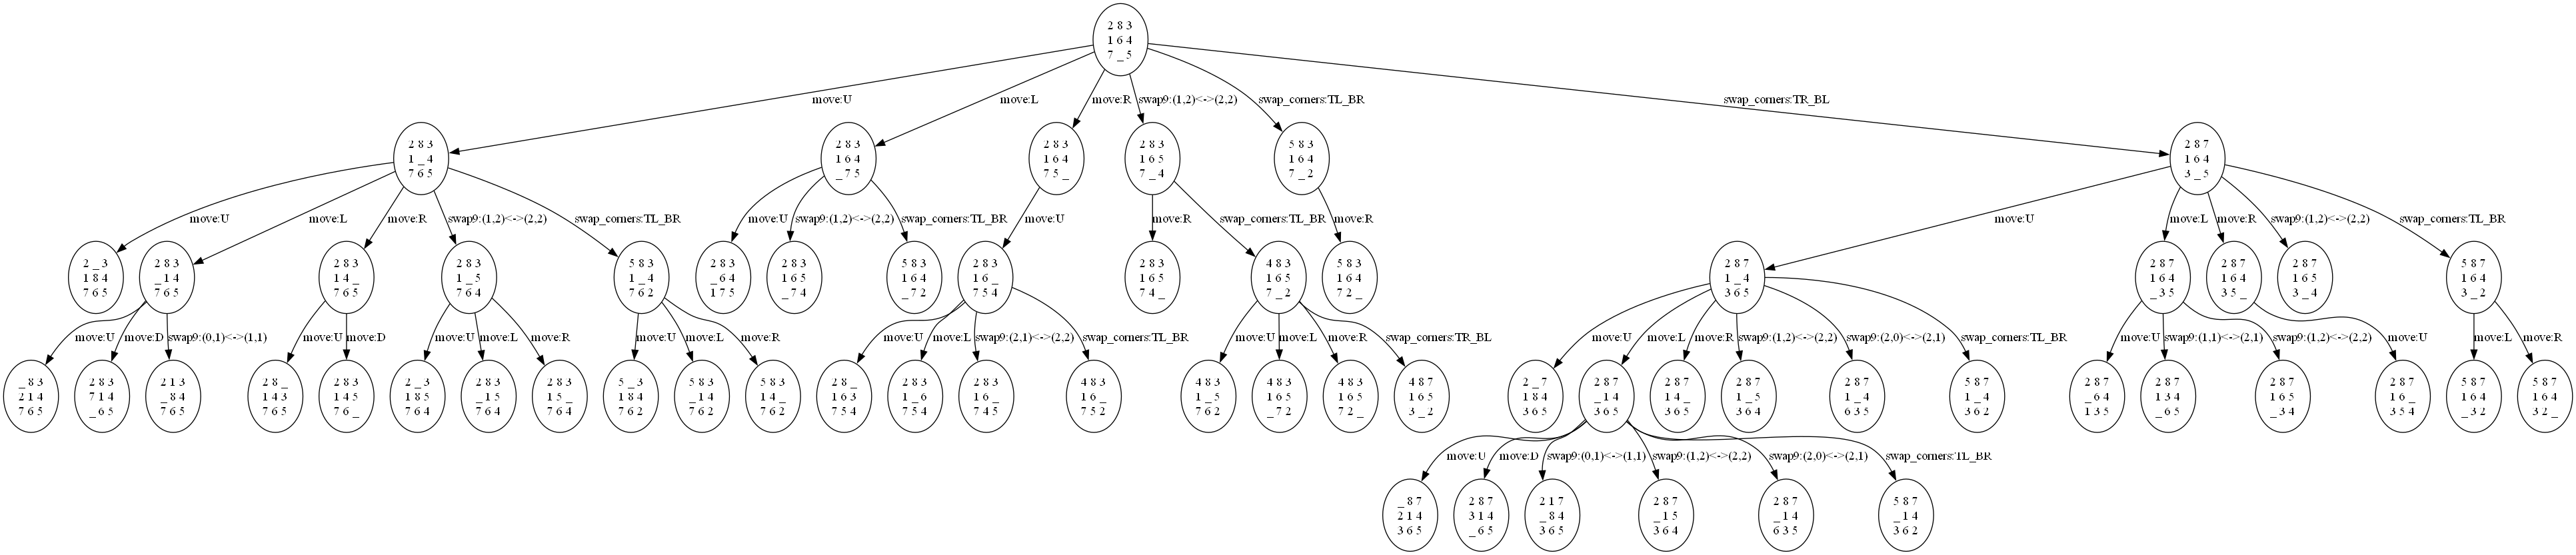

Search tree rendered to: search_tree_10_nodes.png


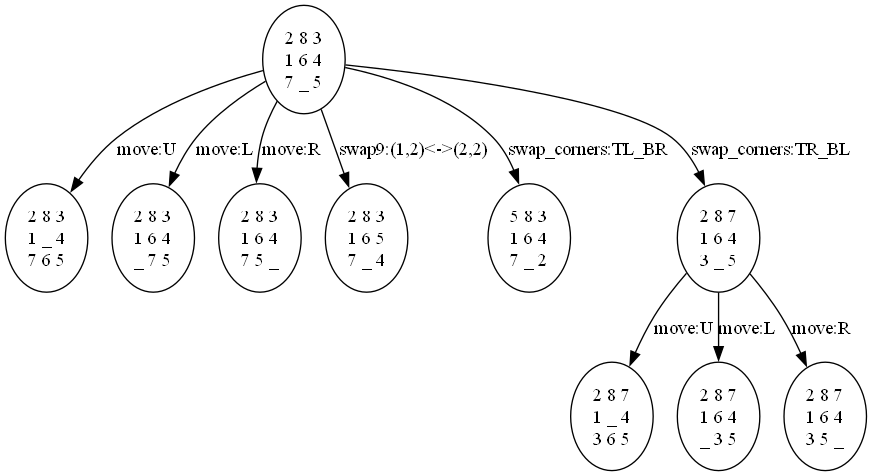

'search_tree_10_nodes.png'

In [ ]:
DOT = r"C:\\Program Files\\Graphviz\\bin\\dot.exe"  # Thay đổi nếu cần
render_search_tree_png(astar, max_edges=60, filename="search_tree_edges", dot_path=DOT)
render_search_tree_png_by_nodes(astar, max_nodes=10, filename="search_tree_10_nodes", dot_path=DOT)